# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [116]:
# import cProfile
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [117]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),  # networkx graph object
    #G=nx.empty_graph(1),
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Parameter priors of nodes (mu and associated uncertainty (standard deviation)), Gaussian by default
        loc=0,
        scale=10,
    ),
    sd_llf=1,  # Standard deviation of the likelihood function (llf) of nodes, assumed known & static
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=1,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=50,  # End time of simulation
    t_sample=1,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=201,  # Number of bins used in distance measures
    sample_range=(
        -5,
        5,
    ),  # Interval over which distance measure distributions are considered
    sampling=True,
)

In [118]:
# Exec times (s)
# ---
# llf_instance:     13.1
# llf improved:     7.4
# rng w. params:    6.78
# rng scaled        6.93

In [119]:
# cProfile.run("nop.run_model_Param(**input)")

In [120]:
out1 = nop.run_model_Param(**input)

print(out1["N_events"])

/home/jens/Documents/Repos/neuro_op/src/neuro_op/utils.py:99: RuntimeWarning: invalid value encountered in divide
  return Q / np.sum(Q)


9996


In [121]:
nop.export_hdf5(out1, "test.h5")

In [122]:
out1 = nop.import_hdf5_Grid("test.h5")

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [123]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
# plt.rcParams.update(
#    {
#        "font.size": 20,
#        "legend.loc": "upper right",
#    }
# )

#### Data analysis 1

Firstly, extract output values for further analysis:

In [124]:
for i in out1.keys():
    print(i)

world
G
N_events
t_end
t_start
t_exec
seed
nodesConj
mu_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 2.,  1.,  3.,  2.,  5.,  8.,  7., 12.,  9., 11., 12.,  3.,  7.,
         4.,  5.,  1.,  4.,  2.,  1.,  1.]),
 array([0.05652244, 0.05950831, 0.06249417, 0.06548004, 0.06846591,
        0.07145178, 0.07443764, 0.07742351, 0.08040938, 0.08339524,
        0.08638111, 0.08936698, 0.09235285, 0.09533871, 0.09832458,
        0.10131045, 0.10429632, 0.10728218, 0.11026805, 0.11325392,
        0.11623978]),
 <BarContainer object of 20 artists>)

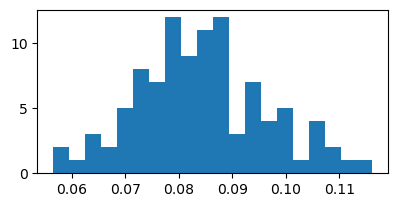

In [125]:
sigmas = []
for i in out1["nodesConj"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
ax.hist(sigmas, bins=20)

[[ 7.81088906e-01 -1.00000000e+00  1.26553309e-01]
 [-1.50214442e+00 -1.00000000e+00  9.12004305e-01]
 [-1.57502392e+00  9.20000000e+01  9.35473631e-01]
 [ 1.07843239e+00 -1.00000000e+00  1.35018670e+00]
 [-4.33630471e+00  4.00000000e+00  1.55639526e+00]
 [-6.62760460e-01 -1.00000000e+00  2.37883629e+00]
 [-3.37258860e-01 -1.00000000e+00  3.28095691e+00]
 [ 7.50846546e-02  9.20000000e+01  3.45072429e+00]
 [-1.56512107e-01  2.00000000e+00  3.89191916e+00]
 [-2.35138873e+00  4.00000000e+00  4.41457425e+00]
 [ 4.65702103e-02 -1.00000000e+00  4.82626885e+00]
 [ 6.85866603e-01 -1.00000000e+00  4.87114843e+00]
 [ 7.75166535e-01 -1.00000000e+00  4.91442154e+00]
 [-6.18049341e-01  2.00000000e+00  4.97693385e+00]
 [-2.29042793e+00  4.00000000e+00  5.16736863e+00]
 [ 5.86540497e-01 -1.00000000e+00  5.69774235e+00]
 [ 1.38210393e+00 -1.00000000e+00  5.81469659e+00]
 [-4.92531482e-01  2.00000000e+00  6.61362051e+00]
 [-7.21802008e-02  9.20000000e+01  7.31801649e+00]
 [-9.04876857e-01 -1.00000000e+

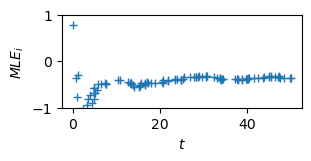

In [126]:
# Implement external sampling routine (or rather test if feasible)
k = 0
nody = out1["nodesConj"][k]
#mu_nody = np.array(out1["mu_nodes"])[:, k][1:]
#
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))
#ax.plot(
#    np.arange(input["t0"], input["t_max"], input["t_sample"]),
#    mu_nody,
#)

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

ax.set_ylim(-1,1)
ax.plot(x_in[:, 2], post_mu, "+", alpha=1)
ax.set_xlabel("$t$")
ax.set_ylabel("$MLE_i$")

print(nody.diary_in)
#fig.savefig("graphics-output/mu_N1.png", dpi=1500)

(51, 100)


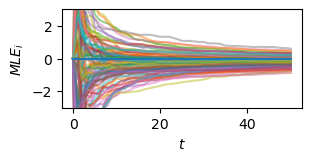

In [127]:
mu_arr = np.array(out1["mu_nodes"])
print(mu_arr.shape)
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))
for i, _ in enumerate(mu_arr.T):
    ax.plot(x, mu_arr.T[i], alpha=0.5, label=f"$\mu_{i}$")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
ax.set_ylim(-3, 3)
ax.plot(x, [0] * len(x), "-", label="$\mu_c$")
#ax.set_yscale("log")
#ax.loglog()
#ax.legend()
fig.savefig("./graphics-output/mu_nodes.png", dpi=1500)

#### Data analysis 2

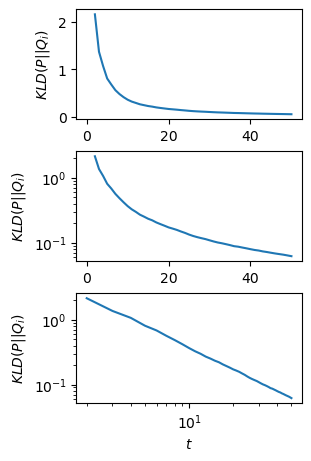

In [128]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
fig, ax = plt.subplots(3,1,constrained_layout=True, figsize=(3, 4.5))
for i, _ in enumerate(ax):
    ax[i].plot(
        input["t_sample"] * np.arange(0, kld.shape[0]),
        kld.mean(axis=1),
        label="$KLD_i$",
    )
    ax[i].set_ylabel("$KLD(P||Q_i)$")
ax[2].set_xlabel("$t$")
ax[1].set_yscale("log")
ax[2].loglog()
fig.savefig("./graphics-output/KLD.png",dpi=1500)

(51, 100)


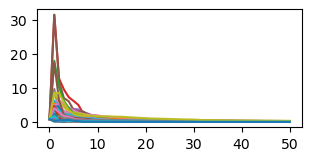

In [129]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
print(kld.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))
for i,_ in enumerate(kld):
    ax.plot(
        input["t_sample"] * np.arange(0, kld.shape[0]),
        kld[:,i],
        label="avg",
    )
#plt.loglog()
# plt.ylim(0, 2)

In [130]:
print(quad_dis.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i in N_iter:
    ax.plot(input["t_sample"] * np.arange(1, quad_dis.shape[0]), quad_dis[1:, i])

NameError: name 'quad_dis' is not defined

In [ ]:
print(lin_dis.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i in N_iter:
    ax.plot(input["t_sample"] * np.arange(1, lin_dis.shape[0]), lin_dis[1:, i])

NameError: name 'lin_dis' is not defined

In [ ]:
arr = np.array(out1["p_distances"])
print(arr.shape)
# (arr[-1, 0, 1, :] ** 2).mean()

KeyError: 'p_distances'